In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import contractions
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import LdaModel
from pprint import pprint
from gensim.models import CoherenceModel
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix as cm
from sklearn.naive_bayes import MultinomialNB

In [ ]:
df_fake_news = pd.read_csv('Fake.csv')

In [ ]:
df_true_news = pd.read_csv('True.csv')

In [ ]:
df_fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
df_true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
df_fake_news['type_news'] = 'fake' # 0
df_true_news['type_news'] = 'true' # 1

In [ ]:
""" unisco i dataset formando un unico df
"""
df = pd.concat([df_fake_news, df_true_news], ignore_index=True)
df.sample(8)

,title,text,subject,date,type_news
31409,Proposed U.S. anti-inversion rules enter final...,"WASHINGTON (Reuters) - U.S. regulations, propo...",politicsNews,"October 4, 2016",true
22710,Bundy Case Ruled a Mistrial – Will Federal Cas...,Mark Anderson 21st Century WireThe Greek phil...,Middle-east,"December 21, 2017",fake
34394,Obama budget envisions $2.9 trillion in 10-yea...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"February 9, 2016",true
19811,BREAKING: VIOLENT HILLARY THUGS Beat Man Holdi...,Protester with Rape sign is tackled at #Clin...,left-news,"Oct 13, 2016",fake
13862,BUMBLING BILL CLINTON Manages To Insult Poland...,The Clinton Campaign just managed to commit th...,politics,"May 21, 2016",fake
38811,Senior Thai royal official dismissed in latest...,BANGKOK (Reuters) - Thailand s Royal Household...,worldnews,"November 8, 2017",true
34232,"At Scalia funeral, led by son, U.S. court batt...",WASHINGTON (Reuters) - U.S. Supreme Court Just...,politicsNews,"February 20, 2016",true
14300,YES! SHERIFF CALLS OUT HILLARY CLINTON For Bla...,Hillary and Bernie are pandering to the Hispan...,politics,"Mar 14, 2016",fake


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   type_news  44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [ ]:
""" creo una copia su cui svolgere le attività del progetto
"""

df_copy = df.copy()

In [ ]:
""" identifico spazi bianchi o righe vuote nella colonna text per successiva eliminazione
"""
blanks = df_copy[df_copy['text'].apply(lambda x: isinstance(x, str) and x.strip() == "")].index.tolist()

print(len(blanks), 'blanks:', blanks)

631 blanks: [10923, 11041, 11190, 11225, 11236, 11241, 11247, 11249, 11267, 11268, 11283, 11284, 11285, 11289, 11290, 11292, 11295, 11296, 11301, 11303, 11304, 11305, 11309, 11314, 11317, 11319, 11322, 11330, 11334, 11335, 11340, 11343, 11348, 11351, 11352, 11357, 11371, 11373, 11374, 11382, 11397, 11402, 11403, 11409, 11410, 11412, 11415, 11419, 11421, 11427, 11431, 11432, 11440, 11448, 11450, 11453, 11462, 11464, 11465, 11472, 11473, 11475, 11478, 11489, 11491, 11493, 11494, 11501, 11505, 11507, 11520, 11531, 11532, 11533, 11538, 11542, 11547, 11549, 11551, 11559, 11563, 11581, 11585, 11589, 11590, 11614, 11624, 11625, 11627, 11631, 11636, 11637, 11643, 11650, 11658, 11661, 11672, 11679, 11681, 11684, 11686, 11688, 11692, 11708, 11718, 11729, 11739, 11753, 11765, 11768, 11777, 11782, 11786, 11788, 11792, 11793, 11803, 11806, 11813, 11821, 11831, 11832, 11841, 11844, 11848, 11854, 11858, 11860, 11863, 11866, 11872, 11874, 11875, 11879, 11881, 11884, 11889, 11893, 11900, 11904, 11906, 

In [ ]:
df_copy.drop(blanks, inplace=True)

In [ ]:
""" limito il rumore dei dati droppando la colonna data perchè non utile ai fini del progetto,
    ed eliminando i duplicati
"""
df_copy.drop(['date'], axis = 1, inplace=True)
df_copy.drop_duplicates(inplace=True)

In [ ]:
""" faccio un check dei valori unici di 'subject'
"""
df_copy['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east', 'politicsNews', 'worldnews'], dtype=object)

In [ ]:
""" distinguo meglio le categorie di notizie riassegnando la nomenclatura
"""
df_copy['subject'] = df_copy['subject'].replace({'news': 'News',
                                                 'politics': 'Political News',
                                                 'Government News': 'Government News',
                                                 'left-news': 'Left News',
                                                 'US_News': 'US News',
                                                 'Middle-east': 'Middle-East News',
                                                 'politicsNews': 'Political News',
                                                 'worldnews': 'World News'})

In [ ]:
""" Applico la lemmatizzazione
"""
lemmatizer = WordNetLemmatizer()

def get_part_of_speech(tag):
    tag_dict = {'J': wordnet.ADJ,   # Aggettivi
                'N': wordnet.NOUN,  # Nomi
                'V': wordnet.VERB,  # Verbi
                'R': wordnet.ADV}   # Avverbi

    return tag_dict.get(tag[0].upper(), wordnet.NOUN)

In [ ]:
""" Funzione per applicare il Cleaning e la lemmatizzazione sul testo
"""
def preprocess_text(texts):
    cleaned_texts = []

    for text in texts:

        text = contractions.fix(text)


        text = re.sub(r'http\S+|www\S+|https\S+', '', str(text), flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)

        words = gensim.utils.simple_preprocess(text, deacc=True)
        filtered_words = [word for word in words if word not in STOPWORDS and len(word) > 5]

        lemmatized_words = [lemmatizer.lemmatize(word, get_part_of_speech(pos_tag([word])[0][1])) for word in filtered_words]

        cleaned_texts.append(lemmatized_words)

    return cleaned_texts

In [ ]:
""" Applico il data cleaning sul testo
"""
df_copy['cleaned_text'] = preprocess_text(df_copy['text'])

In [ ]:
""" Funzione per il cleaning e la lemmatizzazione sul titolo
"""
def preprocess_title(titles):
    cleaned_titles = []

    for title in titles:

        title = contractions.fix(title)

        words = gensim.utils.simple_preprocess(title, deacc=True)
        filtered_words = [word for word in words if word not in STOPWORDS and len(word) > 3]

        lemmatized_words = [lemmatizer.lemmatize(word, get_part_of_speech(pos_tag([word])[0][1])) for word in filtered_words]

        cleaned_titles.append(lemmatized_words)

    return cleaned_titles

In [ ]:
""" Applico il data cleaning sul titolo
"""
df_copy['cleaned_title'] = preprocess_title(df_copy['title'])

In [ ]:
""" Faccio un check sul primo testo pulito
"""
df_copy['cleaned_text'][0]

['donald',
 'couldn',
 'american',
 'instead',
 'enemy',
 'hater',
 'dishonest',
 'reality',
 'couldn',
 'country',
 'rapidly',
 'strong',
 'smarter',
 'friend',
 'supporter',
 'enemy',
 'hater',
 'dishonest',
 'healthy',
 'president',
 'tweet',
 'america',
 'country',
 'rapidly',
 'strong',
 'smarter',
 'friend',
 'supporter',
 'enemy',
 'hater',
 'dishonest',
 'healthy',
 'america',
 'donald',
 'december',
 'expect',
 'president',
 'greet',
 'despicable',
 'infantile',
 'gibberish',
 'decency',
 'gutter',
 'american',
 'citizen',
 'bishop',
 'talbert',
 'december',
 'calvin',
 'december',
 'impeachment',
 'america',
 'accept',
 'regain',
 'control',
 'congress',
 'miranda',
 'december',
 'include',
 'people',
 'wonder',
 'sandoval',
 'december',
 'hater',
 'marlene',
 'december',
 'pollitt',
 'december',
 'include',
 'enemy',
 'fought',
 'donald',
 'december',
 'direct',
 'message',
 'enemy',
 'hater',
 'easter',
 'thanksgiving',
 'anniversary',
 'twitter',
 'daniel',
 'december',
 '

In [ ]:
""". Faccio un check sul primo titolo pulito
"""
df_copy['cleaned_title'][0]

['donald', 'trump', 'sends', 'embarrass', 'year', 'message', 'disturb']

In [ ]:
""" Droppo le colonne title e text nel df lasciando il dataset pulito
"""
df_copy.drop(['title', 'text'], axis=1, inplace=True)

In [ ]:
""" Faccio un chek e salvo il csv pulito
"""
df_copy.sample(7)

,subject,type_news,cleaned_text,cleaned_title
25685,Political News,true,"[washington, reuters, special, counsel, invest...","[russia, probe, counsel, want, interview, seni..."
30133,Political News,true,"[washington, reuters, president, barack, frida...","[obama, point, finger, putin, hack, election]"
37158,World News,true,"[harare, reuters, robert, mugabe, culture, pol...","[zimbabwe, mugabe, go, political, tow, abounds]"
4528,News,fake,"[donald, call, controversial, racially, charge...","[trump, call, racist, policy, force, state]"
18325,Left News,fake,"[president, deputy, assistant, sebastian, appe...","[watch, stone, face, anderson, cooper, get, sc..."
8049,News,fake,"[american, terrier, akamara, siegmund, siegmun...","[bull, near, baby, happen, image]"
17732,Left News,fake,"[country, pretty, coast, america, people, supp...","[anti, trump, actor, george, clooney, matt, da..."


In [ ]:
df_copy.to_csv('df_cleaned.csv', index=False)

**Le fake news sono più frequenti in una determinata categoria?**

In [ ]:
""" Svolgo un conteggio per valori e per proporzione,
    creo un df in cui elenco subject e relativo conteggio e proporzione per le notizie fake
"""
count = df_copy.groupby('type_news')['subject'].value_counts()

proportion = df_copy.groupby('type_news')['subject'].value_counts(normalize=True)

In [ ]:
calculate_distribution = pd.DataFrame({'count': count,
                                      'proportion': proportion}).reset_index()

In [ ]:
fake_news = calculate_distribution[calculate_distribution['type_news'] == 'fake']

In [ ]:
print(fake_news[['subject', 'count', 'proportion']])

            subject  count  proportion
0              News   9050    0.396113
1    Political News   6430    0.281437
2         Left News   4308    0.188559
3   Government News   1498    0.065567
4           US News    783    0.034271
5  Middle-East News    778    0.034053


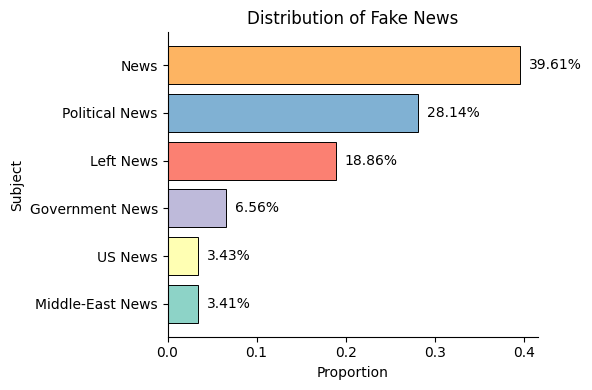

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

fake_news_sorted = fake_news.sort_values('proportion', ascending=True)

colors = plt.cm.Set3(range(len(fake_news_sorted)))

ax.barh(fake_news_sorted['subject'], fake_news_sorted['proportion'], color=colors, edgecolor='black', linewidth=0.7)

ax.set_title('Distribution of Fake News', fontsize=12)
ax.set_xlabel('Proportion', fontsize=10)
ax.set_ylabel('Subject', fontsize=10)

for index, value in enumerate(fake_news_sorted['proportion']):
    ax.text(value + 0.01, index, f'{value:.2%}', va='center', ha='left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.tight_layout()
plt.show()

Il grafico da evidenza di come la maggior parte delle Fake News è nella categoria ' News' con il 39.61% . Essendo una categoria generica è complicato identificare l' argomento preciso a cui fa riferimento il documento.

**Esistono argomenti che sono più soggetti alle fake news?**

In [ ]:
""" Creo un dict che associa ad ogni subject nella lista una serie di testi puliti di notizie fake
    per quel dato argomento
"""
subjects = ['News', 'Political News', 'Left News', 'Government News', 'US News', 'Middle-East News']
fake_cleaned_text_dict = {}

for subject in subjects:
    fake_cleaned_text_dict[subject] = df_copy[(df_copy['type_news'] == 'fake') & (df_copy['subject'] == subject)]['cleaned_text']

In [ ]:
""" Funzione per il topic model
"""
def topic_modeling(data, num_topics, passes=10, random_state=42, chunksize=2000):

    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(text) for text in data]

    # LDA model
    lda_model_multicore = gensim.models.LdaMulticore(corpus=corpus,
                                                     id2word=dictionary,
                                                     num_topics=num_topics,
                                                     passes=passes,
                                                     random_state=random_state,
                                                     chunksize=chunksize,
                                                     per_word_topics=True)

    topics = lda_model_multicore.show_topics(formatted=False)
    topics_sorted = sorted(topics, key=lambda x: x[0])

    for i, (topic_id, topic_words) in enumerate(topics_sorted, start=1):
        print(f"Topic {i}: {topic_words}")

    coherence_model_lda = CoherenceModel(model=lda_model_multicore,
                                         texts=data,
                                         dictionary=dictionary,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'Coherence Score: {coherence_lda:.2f}')

    return lda_model_multicore

In [ ]:
""" Eseguo il topic model su ogni subject definendo un numero di topic nel dict
"""
topics_per_subject = {
    'News': 8,
    'Political News': 7,
    'Left News': 6,
    'Government News': 5,
    'US News': 4,
    'Middle-East News': 3,
}

# Itero attraverso ogni soggetto nel dizionario
for subject, data in fake_cleaned_text_dict.items():

    # Ottengo il numero di topic per il soggetto corrente
    num_topics = topics_per_subject.get(subject)

    print(f"\nTopic Modeling per il soggetto: {subject} con {num_topics} topics")

    # Eseguo il topic modeling su ciascun soggetto
    lda_model= topic_modeling(data, num_topics=num_topics)


Topic Modeling per il soggetto: News con 8 topics
Topic 1: [('people', 0.015193282), ('police', 0.012054788), ('school', 0.007901634), ('feature', 0.006431727), ('officer', 0.0062859054), ('child', 0.005655654), ('christian', 0.0051222933), ('student', 0.00473284), ('family', 0.004581108), ('facebook', 0.0043854197)]
Topic 2: [('climate', 0.009694386), ('reilly', 0.0096386615), ('hannity', 0.009173949), ('change', 0.009172037), ('october', 0.009131326), ('feature', 0.007967741), ('twitter', 0.0072779977), ('president', 0.006606996), ('spicer', 0.006303791), ('question', 0.0061490447)]
Topic 3: [('russia', 0.012466336), ('president', 0.010467149), ('donald', 0.0100139985), ('campaign', 0.009398734), ('investigation', 0.009138706), ('russian', 0.008743387), ('election', 0.007954286), ('administration', 0.007857475), ('report', 0.0077277618), ('official', 0.0072282925)]
Topic 4: [('republican', 0.0366875), ('president', 0.01364574), ('sander', 0.010628818), ('people', 0.010580163), ('ele

**Assegnazione delle etichette descrittive ai rispettivi Topic.**

**Topic modeling per il soggetto 'News':**
- Questioni sociali: Sicurezza e Istruzione.
- Discussioni su Cambiamenti Climatici e Media.
- Elezioni Americane e rapporti internazionali.
- Campagna elettorale ed elettorato.
- Politiche di comunicazione presidenziale.
- Questioni sociali: Sanità.
- Questioni sociali: discussione su aborto.
- Presidenza e Politica Nazionale Americana.

**Topic modeling per il soggetto 'Political News':**
- Sicurezza e Guiustizia.
- Principali candidati alle elezioni Presidenziali.
- Indagini e Politica.
- Questioni sociali: Istruzione e Cultura.
- Social Media e Proteste.
- Diritti e Identità Nazionale.
- Immigrazione e Politiche di Confine.

**Topic modeling per il soggetto ' Left News':**
- Politica elettorale di Hilary Clinton.
- Giustizia Sociale e Polizia.
- Politica Americana e Hilary Clinton.
- Politiche Scolastiche.
- Politiche di Immigrazione.
- Sicurezza e Immigrazione Illegale.


**Topic modeling per il soggetto ' Government News':**
- Politica Internazionale e Presidenziale.
- Sicurezza Nazionale e gestione dell' immigrazione.
- Politiche Governative di Hilary Clinton.
- Politica Nazionale.
- Istruzione Americana legata a politiche di integrazione.

**Topic modeling per il soggetto ' US News':**
- Elezioni Presidenziali e Hilary Clinton.
- Azione politica sul conflitto in Israele dei candidati alle elezioni Americane.
- Sicurezza e Controllo sui Media.
- Relazioni Internazionali e Politica Estera.

**Topic modeling per il soggetto ' Middle-East News':**
- Elezioni Americane ed influenza Politica.
- Elezioni e Politica Internazionale.
- Sicurezza e Media.
- Relazioni Internazionali e Politica Estera.


**I titoli delle fake news presentano dei pattern ricorrenti?**

In [ ]:
title_fake = df_copy[df_copy['type_news']=='fake']['cleaned_title']

In [ ]:
""" Eseguo l' LDA model sui titoli definendo una quantità di topic pari ad 8
"""

lda_model_title = topic_modeling(title_fake, 8)

Topic 1: [('video', 0.037229832), ('black', 0.02207496), ('obama', 0.021673353), ('trump', 0.020139376), ('muslim', 0.013515659), ('terrorist', 0.013138587), ('life', 0.011379609), ('police', 0.011150914), ('american', 0.011037986), ('syria', 0.009862705)]
Topic 2: [('video', 0.06158817), ('trump', 0.060856987), ('hillary', 0.033117067), ('watch', 0.021512462), ('clinton', 0.015939357), ('donald', 0.0125478655), ('news', 0.011281361), ('president', 0.011003932), ('host', 0.0071910215), ('get', 0.0068732146)]
Topic 3: [('hillary', 0.033236645), ('video', 0.0221597), ('clinton', 0.022074187), ('bernie', 0.015340219), ('sander', 0.0135368295), ('break', 0.013407577), ('email', 0.012398192), ('state', 0.012049224), ('plan', 0.008909277), ('vote', 0.007848268)]
Topic 4: [('room', 0.032770306), ('boiler', 0.030343806), ('white', 0.028762545), ('obama', 0.021645632), ('trump', 0.01785363), ('house', 0.01640307), ('video', 0.015869321), ('medium', 0.013614003), ('illegal', 0.012897091), ('fake

**Etichette:**
- Comunità Afroamericne e questioni legate al terrorismo.
- Media ed elezioni Americane.
- Scandali e primarie Democratiche.
- Politica e Media.
- Confronti Politici e Talk Show.
- Trump e l' uso dei Media.
- Relazioni USA- Russia ed implicazioni Legali.
- Trump e le Politiche Scolastiche.


In [ ]:
""" Creo un oggetto TfidfVectorizer e trasformo i titoli puliti ridefinendo una stringa legando le parole con uno spazio
"""
tfidf_vectorizer = TfidfVectorizer()
df_copy['cleaned_title'] = df_copy['cleaned_title'].apply(lambda x: ' '.join(x))

In [ ]:
""" creo una matrice sparsa di TF-IDF
"""
tfidf_matrix = tfidf_vectorizer.fit_transform(df_copy['cleaned_title'])

In [ ]:
""" Converto la matrice sparsa creata in precedenza in un array e poi in un df,
    in cui ogni colonna rappresenta un termine del vocabolario ed ogni riga è un titolo
"""
tfidf_array = tfidf_matrix.toarray()
tfidf_df = pd.DataFrame(tfidf_array, columns = tfidf_vectorizer.get_feature_names_out())

In [ ]:
""" Ottengo una lista ordinata delle parole più rilevanti nel corpus in base ai pesi TF-IDF
"""
tfidf_sum = tfidf_df.sum().sort_values(ascending=False).round(2)

In [ ]:
""" Creo un nuovo df del risultato della somma dei pesi per calcolare la proporzione di ciascun termine
    rispetto alla somma del totale dei pesi TF-IDF
"""
tfidf_df = pd.DataFrame(tfidf_sum, columns=['tfidf'])
tfidf_df['proportion'] = tfidf_df['tfidf']/ tfidf_df['tfidf'].sum()

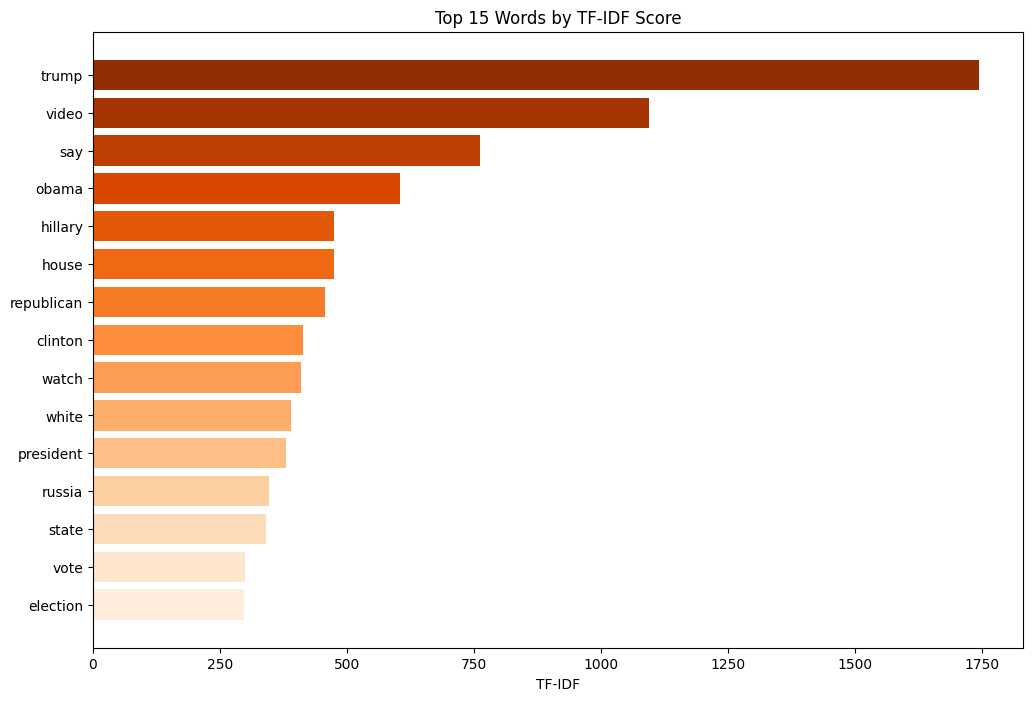

              tfidf  proportion
trump       1742.50    0.014638
video       1093.39    0.009185
say          761.38    0.006396
obama        604.02    0.005074
hillary      473.95    0.003982
house        473.41    0.003977
republican   455.87    0.003830
clinton      413.49    0.003474
watch        409.79    0.003443
white        389.92    0.003276
president    379.28    0.003186
russia       346.62    0.002912
state        340.02    0.002856
vote         298.77    0.002510
election     297.96    0.002503


In [ ]:
""" Visualizzo le prime 15 parole in termine di pesi TF-IDF
"""
top_words = tfidf_df.head(15)

palette = sns.color_palette("Oranges", len(top_words))[::-1]

plt.figure(figsize=(12, 8))
plt.barh(top_words.index, top_words['tfidf'], color=palette)
plt.xlabel('TF-IDF')
plt.title('Top 15 Words by TF-IDF Score')
plt.gca().invert_yaxis()

plt.show()

print(tfidf_df.head(15))

**Analisi di Machine Learning e addestramento del modello con algoritmo di Regressione Logistica**

In [ ]:
""" Definisco variabile indipendente e dipendente
"""
X = df_copy['cleaned_text']
y = df_copy['type_news']

In [ ]:
X = X.apply(lambda x: ' '.join(x))

In [ ]:
""" Splitto il dataframe in set di addestramento e set di test, assegnando a quest' ultimo quota del 20%
"""
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
vectorizer = TfidfVectorizer()

x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(x_train_vectorized, y_train)

LogisticRegression()

In [ ]:
""" valuto le metriche su set di addestramento e su set di test ponendo
    attenzione sul valore di accuracy per determinare la presenza o meno di overfitting
"""
y_train_pred = lr_model.predict(x_train_vectorized)
print("Report di classificazione sul set di addestramento:")
print(classification_report(y_train, y_train_pred))
print("Accuracy sul set di addestramento:", accuracy_score(y_train, y_train_pred))

y_pred = lr_model.predict(x_test_vectorized)
print("\nReport di classificazione sul set di test:")
print(classification_report(y_test, y_pred))
print("Accuracy sul set di test:", accuracy_score(y_test, y_pred))

Report di classificazione sul set di addestramento:
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99     18301
        true       0.99      0.99      0.99     16942

    accuracy                           0.99     35243
   macro avg       0.99      0.99      0.99     35243
weighted avg       0.99      0.99      0.99     35243

Accuracy sul set di addestramento: 0.9870612603921346

Report di classificazione sul set di test:
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      4546
        true       0.98      0.98      0.98      4265

    accuracy                           0.98      8811
   macro avg       0.98      0.98      0.98      8811
weighted avg       0.98      0.98      0.98      8811

Accuracy sul set di test: 0.9803654522755646


In [ ]:
""" Recuepero i nomi delle caratteristiche dal TfidfVectorizer per avere un array contenente i termini del vocabolario
    utilizzati per creare le caratteristiche TF-IDF
"""
feature_names = vectorizer.get_feature_names_out()

# Ottiengo gli indici ordinati
sorted_coef_index = lr_model.coef_[0].argsort()

print("Top positive features:\n", feature_names[sorted_coef_index[-20:]])
print("Top negative features:\n", feature_names[sorted_coef_index[:20]])

Top positive features:
 ['militant' 'london' 'spokeswoman' 'moscow' 'prosecutor' 'kill'
 'presidential' 'united' 'democratic' 'statement' 'representative'
 'spokesman' 'minister' 'friday' 'monday' 'washington' 'tuesday'
 'thursday' 'wednesday' 'reuters']
Top negative features:
 ['feature' 'image' 'hillary' 'america' 'century' 'american' 'entire'
 'actually' 'breitbart' 'twitter' 'terrorist' 'wouldn' 'report' 'course'
 'pretty' 'taxpayer' 'morning' 'reportedly' 'reason' 'subscribe']


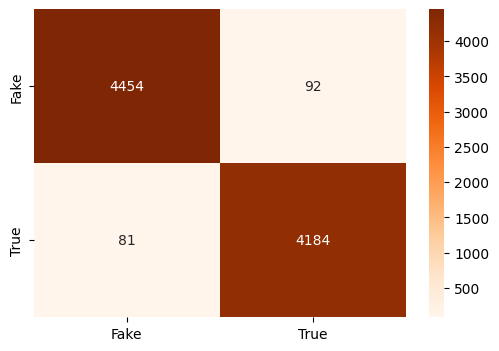

In [ ]:
confusion_matrix = cm(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.show()

In [ ]:
""" esporto in formato pickle
"""
with open('machine_learning_model.pkl','wb') as file:
    pickle.dump(lr_model, file)

**Analisi di Natural Language Processing e addestramento del modello con algoritmo Bayesiano**

In [ ]:
bayesian_model = MultinomialNB()
bayesian_model.fit(x_train_vectorized, y_train)

MultinomialNB()

In [ ]:
y_pred = bayesian_model.predict(x_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.92      0.92      0.92      4546
        true       0.92      0.92      0.92      4265

    accuracy                           0.92      8811
   macro avg       0.92      0.92      0.92      8811
weighted avg       0.92      0.92      0.92      8811



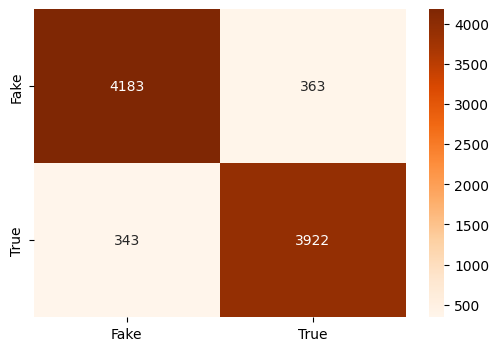

In [ ]:
confusion_matrix = cm(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.show()

In [ ]:
""" esporto in formato pickle
"""
with open('bayesian_model-pkl','wb') as file:
    pickle.dump(bayesian_model, file)

In [ ]:
""" testo il modello con una frase non presente nel df
"""
sentence = 'Hilary Clinton, in 2024, was elected President of the USA, marking a turning point in American history!'

In [ ]:
""" pulisco la frase
"""
sentence_cleaned = preprocess_text([sentence])
sentence_cleaned

[['hilary',
  'clinton',
  'elect',
  'president',
  'mark',
  'turn',
  'american',
  'history']]

In [ ]:
sentence_cleaned = ' '.join(sentence_cleaned[0])

In [ ]:
""" machine learning model
"""
sentence_vectorized = vectorizer.transform([sentence_cleaned])
prediction = lr_model.predict(sentence_vectorized)
print(prediction)

['fake']


In [ ]:
""" NLP model
"""
sentence_vectorized = vectorizer.transform([sentence_cleaned])
predction = bayesian_model.predict(sentence_vectorized)
print(prediction)

['fake']
